*Quick note: make sure you have the following packages installed before using this notebook!*

*Note that ``batman`` is installed via ``pip install batman-package``, NOT ``pip install batman``!*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import batman
import emcee
import corner

# Model Fitting with ``emcee``

Hi! I'm Drew, your mentor for the Intro2Astro workshop. In this Python notebook, I'll be showing you how to use ``emcee`` and walking you through an example of using it with real-life data.

More specifically, we're going to try modeling transits of a real exoplanet, WASP-94 b, using data from the TESS satellite. Let's go ahead and walk through it!

### Part 1: Making Our Model

Say we're in a situation where we have some real-life data we obtained measuring an exoplanet transit (like, say, WASP-94 b!) We know what an exoplanet transit *should* look like given the orbital parameters of that exoplanet, but we don't know *what* those parameters are.

How do we find those parameters? We could just make a billion random guesses and pick the one that looks the best, but that feels needlessly complicated. Alternatively, we could just use ``emcee`` instead! ``emcee`` is a Markov-Chain Monte Carlo sampler that tries to find the best parameters that fit your model, and the probability distribution of these paramters to boot.

Let's start by getting our data: the Sector 27 long-cadence observations from TESS. I've gone ahead and normalized the data, as well as compiled the data into a .csv file we can access:

In [2]:
data = pd.read_csv("WASP-94_data.csv")
data[0:10]

,Time,Flux,Flux Error
0,2036.283907,1.000139,0.000999
1,2036.286684,1.001894,0.001001
2,2036.288073,1.000033,0.001000
3,2036.289462,1.002047,0.001001
4,2036.290851,1.001003,0.001000
5,2036.292240,1.003030,0.001001
6,2036.293629,1.000142,0.001001
7,2036.295018,0.998115,0.001000
8,2036.296407,1.000174,0.001000
9,2036.297796,1.000899,0.001000


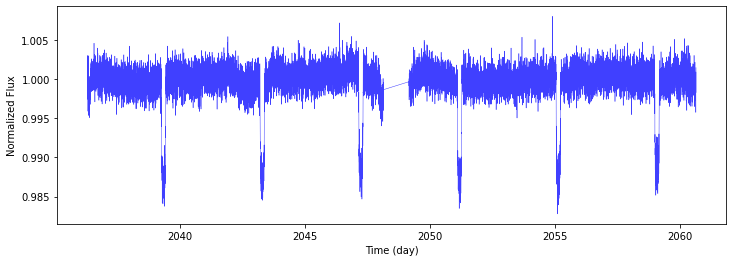

In [3]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(data['Time'], data['Flux'], lw = 0.5, color = 'blue', alpha = 0.75)
ax.set_xlabel("Time (day)")
ax.set_ylabel("Normalized Flux");

This is what our data looks like: we have our times, the normalized flux of the star at that time, and the error of that observation. We can pretty clearly see a transit every 4-ish days, so this is a really good planetary candidate!

Now, let's go ahead and write our model: a function that takes in orbital parameters of the planet and spits out our expected fluxes and times. To do this, we'll be using ``batman``, a Python module designed for modeling exoplanet transits.

**Important note**: In this fit, we won't be using the standard orbital parameters of the star. ``batman`` accepts the following orbital parameters intead:

• $t_0$, a time of inferior conjunction of the planet

• $p$, the orbital period (in the same unit as $t0$, in our case days)

• $R_p$, the radius of the planet (as a fraction of the radius of our star)

• $a$, the semimajor axis of our planet (as a multiple of the radius of our star)

• $i$, the inclination of our planet's orbit (in degrees)

There *are* two other parameters ``batman`` takes as inputs:

• $\varpi$, the longitude of periastron of our planet's orbit (in degrees)

• $e$, the eccentricity of our planet's orbit.

However, we will not be fitting these two, since the more parameters you have, the slower the fitting goes, and because these two are very tough to fit with transits! Many people don't even fit longitude of periastron in their actual papers, and WASP-94 b's actual eccentricity was only fit for by combining transit observations and radial velocity data. We will set those two to 180° and 0 respectively for our fits.

We can, if we want, convert these into a planetary radius and another set of six orbital parameters (most commonly $a, e, i, \omega, \Omega, M$), but that's outside of the scope of this notebook. (If you especially want to learn how to convert these values, that's the premise of most of §1 of Scott Tremaine's *Dynamics of Planetary Systems* textbook.)

In [4]:
times = np.array(data['Time'])

def exoplanet_model(params):
    radius, period, semimajor_axis, inclination, t0 = params

    model     = batman.TransitParams()                     # object to store transit parameters
    model.t0  = t0                                         # time of inferior conjunction
    model.per = period                                     # orbital period, in days
    model.rp  = radius                                     # planet radius (in units of stellar radii)
    model.a   = semimajor_axis                             # semi-major axis (in units of stellar radii)
    model.inc = inclination                                # orbital inclination (in degrees)
    model.ecc = 0.                                         # eccentricity
    model.w   = 180.                                       # longitude of periastron (in degrees)
    
    model.limb_dark = "quadratic"                          # limb darkening model
    model.u = [0.1, 0.3]                                   # limb darkening coefficients [u1, u2, u3, u4]

    m = batman.TransitModel(model, times, fac = 1e-3)      # initializes model
    flux = m.light_curve(model)                            # calculates light curve

    return flux

Okay! Now that we have a function that inputs our parameters and outputs the model flux at given times, let's go ahead and put in some parameters!

I guessed at these ones by playing around with the parameters and seeing how the model looks. (Feel free to play around with your own values, too, and get a feel for how they affect the transits.)

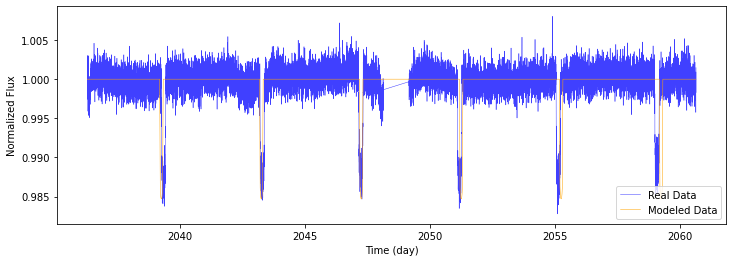

In [5]:
initial_guess = [0.12, 4.0, 9., 86.5, 2039.25]
modeled_flux = exoplanet_model(initial_guess)
modeled_flux

fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(data['Time'], data['Flux'], lw = 0.5, color = 'blue', alpha = 0.75, label = "Real Data")
ax.plot(data['Time'], modeled_flux, lw = 0.5, color = 'orange', alpha = 1.0, label = "Modeled Data")
ax.set_xlabel("Time (day)")
ax.set_ylabel("Normalized Flux")
ax.legend(loc = "lower right");

Okay, we can see that that's not *perfect*, but it's a pretty good first guess! How can we *quantify* how good it is, though?

To answer that, we can define the *log-likelihood* of our model by

\begin{equation}
LL = -\frac{1}{2} \sum_{n} \frac{(f_n - m_n)^2}{\sigma_n^2}
\end{equation}

where $f_n$ is the $n$th data point of our real flux, $m_n$ is the $n$th data point of our modeled flux, and $\sigma_n$ is the $n$th error of our real flux.

Essentially, the function is saying that we want to minimize the difference between the real and modeled fluxes, but we're punishing data points with high error less harshly. **Our goal is, with a few caveats, to maximize this log-likelihood.**

(This is called the *Pearson chi-squared test*, and it's a pretty common method of calculating your model likelihood, by the way!)

Now, let's try coding that up:

In [6]:
def log_likelihood(params):
    model_flux = exoplanet_model(params)
    real_flux  = np.array(data["Flux"])
    flux_err   = np.array(data["Flux Error"])
    return -0.5 * np.sum(np.power((model_flux - real_flux) / flux_err, 2))

Now here, we might run into a problem. One of our parameters is $t_0$, a time of transit. But doesn't *any* time of transit work? If a planet transits on day 2039 and day 2043, how do we know which one is 'right'?

Well, the answer is that *both* of those are right! These are both valid times of transit. But we don't want our model to get confused, so we need to find a way to tell it that, well, you should pick 2039 and not 2043. How do we do that?

We use what's called a *prior*. While I won't get *too* in the weeds of the math behind it, a prior is essentially your 'initial belief' as to what the true values of our parameters are. As an example, we can *see* on our plot that the planet transits 6 times in the 20-day period between day 2039 and 2059, so it has a period of roughly 3.5 days. If the ``emcee`` fit finished and told you that the best-fit period was 100 days, you wouldn't believe it, right? You'd assume your model was wrong instead, or the code made a math error, before you actually accepted that the period was that large. (This method of finding what values have the highest probability of belief, by the way, is part of the basis of what's called *Bayesian statistics*.)

A prior lets you *quantify* this initial belief in a way that the computer understands. To do this, we'll define a *log-prior*:

\begin{equation}
\textrm{log likelihood} = \textrm{log posterior} + \textrm{log prior}
\end{equation}

In this case, we'll be simple and use a uniform prior, which has a value of $0$ if you believe the results (if it's within a set of bounds you set) and a value of $-\infty$ if you don't believe it (if it's not within these bounds), meaning it should never find an value of a parameter not within these priors. Let's code these priors up!

In [7]:
def log_prior(params):
    radius, period, semimajor_axis, inclination, t0 = params
    if (period < 3.) or (period > 5.):                # Let's say we will only believe that the period is within [3 days, 5 days]
        return -np.inf
    elif (t0 < 2038.) or (t0 > 2040.):                # Let's say we only want a t0 within [day 2038, day 2040]
        return -np.inf
    elif (radius < 0.05):                             # the radius of the planet obviously has to be above 0
        # but let's say 0.05 to be safe, since batman gets upset whenever you try to model really small planets
        return -np.inf
    elif (semimajor_axis < 1.):                       # if a < 1 solar radius, then the planet would be inside the star!
        return -np.inf
    elif (inclination < 0.) or (inclination > 90.): # this has to be on [0°, 180°]
        # but it's hard to tell the difference between, say, 89° and 91°, so let's just restrict it to be above 90.
        return -np.inf
    else:
        return 0

def log_posterior(params):
    log_posterior = log_likelihood(params) + log_prior(params)
    if (np.isnan(log_posterior)):                    # just in case something breaks and it returns NaN, so emcee doesn't get upset
        return -np.inf
    else:
        return log_posterior

There we go! We don't have any reason *not* to use any other form of prior, though other priors exist (like a Gaussian prior, for example.) We also don't have any reason to place restrictions on any other parameters, either (though feel free to play around with adding them and see how the results change!)

### Part 2: Using ``emcee``

Alright, so now we have our likelihood function! Let's go ahead and learn how to use ``emcee``.

As a quick reminder, ``emcee`` works by way of 'walkers'. Walkers 'traverse' probability space by starting at a given location, and, at each timestep, picking a random point nearby them. If the random point is a *better* fit (meaning it has a higher log-likelihood) than its current location, it will move to it; if it's a *worse* fit than its current location, it will move to it with a small probability dependent on the difference between the two fits (meaning it has a decent chance of moving -- also known as the new location *being accepted* -- if the new spot is only a little worse, and a very low chance at accepting the new location if it's much worse.)

Let's go ahead and pick initial points for our walkers! We saw that my initial 'guess' looked fairly good before, so let's use that as our initial point for our walkers. (We'll also slightly offset all the walkers from each other, so they don't immediately move in the same direction.)

Let's use 32 walkers. The exact amount we use isn't super important, but make sure to use a lot (at least twice the number of parameters you're fitting for!) More is better, but more also takes longer. I recommend using as many as your computer can manage in a reasonable amount of time (which will be a lot if your computer can parallelize well, but I'm writing and testing this on a lightweight laptop that can't handle that.)

In [8]:
np.random.seed(1) # Just so we can replicate this
walker_positions = initial_guess + 1e-4 * np.random.randn(32, 5)
nwalkers, ndim = walker_positions.shape

And let's go ahead and let our fit run! We'll get more into figuring out how long to let it run for in a second, but as an initial guess, we'll have it run for 1,000 steps.

(Let's note that ``emcee`` can take a while, and the more parameters you add the longer it takes! The progress bar on the bottom shows an estimate of how long it'll take to finish if you set the ``progress`` flag to True.)

In [9]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(walker_positions, 1000, progress=True);

100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 33.85it/s]


### Part 3: Taking a look at our results

Perfect! We ran our MCMC fit. Let's take a look at the MCMC fit itself before the results, and plot how the walkers moved over time!

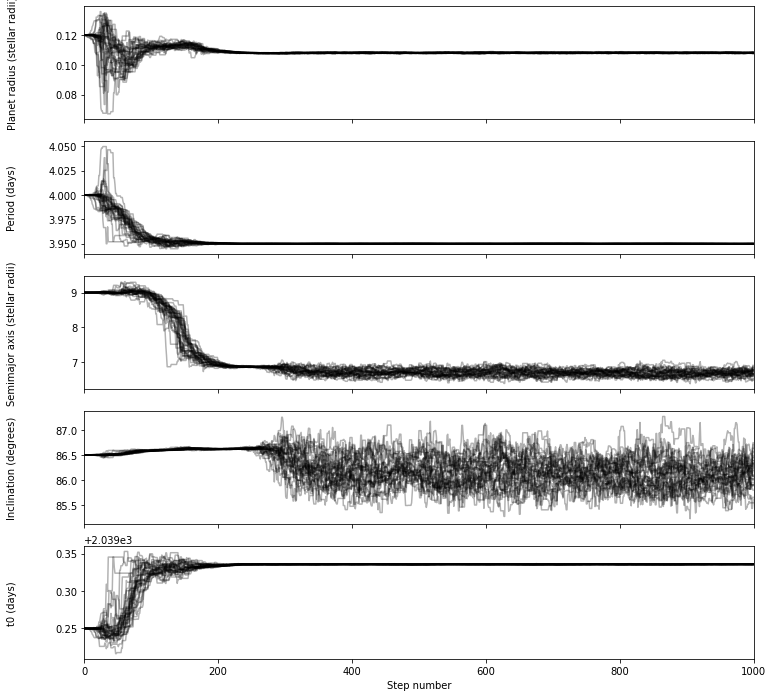

In [10]:
fig, axes = plt.subplots(5, figsize=(12, 12), sharex = True)
samples = sampler.get_chain()
labels = ["Planet radius (stellar radii)", "Period (days)", "Semimajor axis (stellar radii)", "Inclination (degrees)", "t0 (days)"]
for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("Step number");

That looks pretty good! We can see the walkers all moving (mostly) in unison to a good fit over time.

Let's go ahead and check a few common diagnostics for MCMC fits. The first is the *acceptance fraction*. This is the fraction of randomly sampled locations that the walkers succesfully moved to. Too high a fraction means that our walkers aren't converging and are just moving willy-nilly, while too low a fraction means that our walkers are stuck in likelihood maxima (probably local maxima, meaning they're not at the best location!)

This value should, optimally, be about 45% if we're only fitting for one parameter, decreasing to 20-30% for a lot of parameters (5+). That said, unless it's *really* low (<10%) or *really* high (>60%) it's probably okay. Let's see what it is for us:

In [11]:
np.mean(sampler.acceptance_fraction)

0.5229999999999999

That's a little high, but it looks like a reasonable fraction.

The next diagnostic to check is the *autocorrelation time*. *Autocorrelation* is the degree of similarity between successive values of a time series (like individual steps in a chain), so the autocorrelation time represents, in essence, the amount of time it takes for your walkers to 'forget' their original location. The idea is that no matter where you start your walkers, they *should* converge to the best-fit parameters, but this might take longer or shorter depending on where you start!

A good rule of thumb is to make sure you run your code for at least 50x the autocorrelation time of all your variables (some people use 20x instead, but better to be safe than sorry!) Let's see what the autocorrelation times for these parameters are.

In [12]:
tau = sampler.get_autocorr_time(quiet = True)
print(tau)

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 55.5803988   69.92393892 113.58075706 100.95909073  74.8003482 ]


[ 55.5803988   69.92393892 113.58075706 100.95909073  74.8003482 ]


Ah, that's an issue! It seems like we haven't run our ``emcee`` fit for 50x the autocorrelation time. Let's run it for a lot longer -- 10,000 steps, so another 9,000 -- and see if it's been run for long enough then:

In [ ]:
sampler.run_mcmc(None, 9000, progress=True);

 23%|████████▊                              | 2048/9000 [01:00<03:20, 34.64it/s]

Okay, let's check now.

In [ ]:
tau = sampler.get_autocorr_time(quiet = True)
print(tau)

Perfect! We've run our fit for long enough. (For the future, a good practice to avoid running it for *too* long is to have code continually check every $n$ steps and keep running it until you've run it for 50x the maximum autocorrelation time.)

In [ ]:
fig, axes = plt.subplots(5, figsize=(12, 12), sharex = True)
samples = sampler.get_chain()
labels = ["Planet radius (stellar radii)", "Period (days)", "Semimajor axis (stellar radii)", "Inclination (degrees)", "t0 (days)"]
for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("Step number");

And let's make sure our acceptance fraction isn't too high:

In [ ]:
np.mean(sampler.acceptance_fraction)

Alright! Our diagnostics all look good. Let's get the actual parameters from our fit!

To do this, we can remove the initial steps, called the *burn-in*, while the model was still getting to the best-fit parameters. Let's remove, say, five times the maximum autocorrelation time just to be safe.

From there, we can note that we have a *lot* of different steps the chain took. We can do what's called *thinning*, too: like we mentioned, the individual steps of a walker aren't actually independent! To address this, we can instead take every *n*th step of the walkers (*n* is traditionally the maximum autocorrelation time) and use the shortened list of steps for statistics instead.

Finally, we'll *flatten* our samples -- essentially turning it into a single 2D array of our parameters and steps.

In [ ]:
max_autocorr_time = round(max(tau))
flat_samples = sampler.get_chain(discard = 5 * max_autocorr_time, thin = max_autocorr_time, flat = True)
print(flat_samples.shape)

And let's print our parameters and their errors!

In [ ]:
params = []
labels = ["Planet radius (stellar radii)", "Period (days)", "Semimajor axis (stellar radii)", "Inclination (degrees)", "t0 (days)"]
for i in range(5):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{labels[i]} {' ' * (30 - len(labels[i]))} : {mcmc[1]:.4f} {' ' * (5 - len((str)(round(mcmc[1]))))}  - {q[0]:.4f} {' ' * (5 - len((str)(round(q[0]))))} + {q[1]:.4f}")
    params.append(mcmc[1])

Next, we can use the ``corner`` module to make what's called a *corner plot*. This plot shows the distribution of parameters as well as their correlation, and can be really helpful for identifying degeneracies in your data! (For example, in other planet detection methods, there's often a degeneracy between mass and inclination, meaning a high-mass low-inclination planet can show the same signal as a low-mass high-inclination planet, and so there's likely goint to be an anticorrelation between these parameters. The same often applies to mass and eccentricity, too.)

In [ ]:
labels = ["$R_p (R_s)$", "$P$ (d)", "$a (R_s)$", "$i (°)$", "$t_0$ (d)"]
fig = corner.corner(flat_samples, labels = labels,
                    quantiles = [0.16, 0.5, 0.84], show_titles = True, title_fmt = '.4f');

That looks pretty good! We see some degeneracy between the inclination and semimajor axis, as well as between the period and time of transit, but these are to be expected. We alslo see that our distributions of parameters looks roughly normal, too (which isn't a requirement of a good fit, but is certainly very reassuring regardless!)

Finally, let's just plot our model with the median parameters here and see how it looks:

In [ ]:
modeled_flux = exoplanet_model(params)
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(data['Time'], data['Flux'], lw = 1., color = 'blue', alpha = 0.75, label = "Real Data")
ax.plot(data['Time'], modeled_flux, lw = 1., color = 'orange', alpha = 0.75, label = "Modeled Data")
ax.set_xlabel("Time (day)")
ax.set_ylabel("Normalized Flux")
ax.legend(loc = "lower right");

That fit looks good! I'd say this was a successful model fitting.

If you want to learn more about [``emcee``](https://emcee.readthedocs.io/en/stable/), [``batman``](https://lkreidberg.github.io/batman/docs/html/index.html), or [``corner``](https://corner.readthedocs.io/en/latest/), feel free to read their documentation linked here.